# Investigating the relationship between station observations and NZRA

## Experiment Setup
- do imports
- set up project wide settings, variables, hyperparameters

In [1]:
%load_ext autoreload

In [2]:
# imports from this repo
%autoreload 2
from convcnp_assim_nz.config.logging_config import setup_logging
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths, get_env_var
from convcnp_assim_nz.utils.variables.var_names import TEMPERATURE, PRECIPITATION, SURFACE_PRESSURE, HUMIDITY, WIND_SPEED, WIND_DIRECTION, WIND_U, WIND_V, VERTICAL_VELOCITY, GEOPOTENTIAL, SUN_CULMINATION, SUN_ANGLE, SEA_SURFACE_TEMPERATURE, TEMPERATURE_MIN, TEMPERATURE_MAX, SHORTWAVE_FLUX_DOWN, BAND_3, BAND_9, BAND_13, ELEVATION, TOPOGRAPHIC_POSITION_INDEX, LAND_SEA_MASK
from convcnp_assim_nz.utils.variables.coord_names import LATITUDE, LONGITUDE, TIME
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.data_processing.era5_processor import ProcessERA5
from convcnp_assim_nz.data_processing.station_processor import ProcessStations
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius

import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import deepsensor.torch
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from mpl_toolkits.basemap import Basemap
import pickle
import logging
from datetime import datetime
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device, concat_tasks
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds
from deepsensor.data.utils import compute_xarray_data_resolution, compute_pandas_data_resolution

Loading environment variables from: /esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.env


In [3]:
years = [2013, 2014]
target_variable = [TEMPERATURE]
target_variable_diff = [f"{var}_diff" for var in target_variable]
time_slice = slice(f'{min(years)}-01-02T00:00:00', f'{max(years)}-12-30T23:00:00')

n_timestamps = 100

use_absolute_filepaths(True)

In [4]:
# load datasets

# data processors
nzra_processor = ProcessNZRA()
era5_processor = ProcessERA5()
station_processor = ProcessStations(mode="csv")

nzra_ds = nzra_processor.load_ds(years=years)
era5_ds = era5_processor.load_ds(years=years)

if TEMPERATURE in target_variable:
    csv_file = '2013-2018_temps.csv'

stations_df = station_processor.load_df(target_variable, csv_file=csv_file, year_start=min(years), year_end=max(years))

Loaded CSV with length 10897852
Loaded CSV with length 3328203


In [5]:
# Datasets need to be resampled to hourly frequency, + de-duplicated
nzra_ds = nzra_ds.sel(time=time_slice).chunk({"time": 24})
era5_ds = era5_ds.sel(time=time_slice).chunk({"time": 24})

target_time = nzra_ds.time.resample(time="1h").first()

nzra_ds = nzra_ds.reindex(time=target_time, method="nearest", tolerance="5min")
era5_ds = era5_ds.reindex(time=target_time, method="nearest", tolerance="5min")

unique_times, unique_indices = np.unique(nzra_ds['time'].values, return_index=True)
nzra_ds = nzra_ds.isel(time=sorted(unique_indices))
era5_ds = era5_ds.isel(time=sorted(unique_indices))

all_times = nzra_ds['time'].values
times = np.random.choice(all_times, size=n_timestamps, replace=False)
times = np.unique(times)

selected_indices = np.isin(nzra_ds['time'].values, times).nonzero()[0]
nzra_ds = nzra_ds.isel(time=selected_indices)
era5_ds = era5_ds.isel(time=selected_indices)

target_time_pd = pd.to_datetime(times)
stations_df = stations_df[stations_df['time'].isin(target_time_pd)]

In [6]:
# preprocess the stations
stations_df = stations_df[target_variable + [LATITUDE, LONGITUDE, TIME] + ['AGENT_NO', 'NAME']]

stations_reset = stations_df.reset_index()
stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE, 'AGENT_NO', 'NAME']).resample("1h", on=TIME).mean()[target_variable]
stations_resample = stations_resample.reset_index().set_index([TIME, LATITUDE, LONGITUDE]).sort_index()

# resample stations to times in NZRA
target_time_pd = pd.to_datetime(target_time.values) 
stations_resample = stations_resample[stations_resample.index.get_level_values('time').isin(target_time_pd)]

# crop the stations to NZ bounds
crop_bottom = nzra_ds.lat.min().item()
crop_top = nzra_ds.lat.max().item()
crop_left = nzra_ds.lon.min().item()
crop_right = nzra_ds.lon.max().item()

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

In [7]:
# preprocess NZRA
if TEMPERATURE in nzra_ds.data_vars:
    nzra_ds[TEMPERATURE] = kelvin_to_celsius(nzra_ds[TEMPERATURE])

nzra_ds = nzra_ds[target_variable]

# ensure lat/lon indices don't have numerical precision issues
nzra_ds = nzra_ds.assign_coords(lat=np.round(nzra_ds.lat.values, decimals=4), lon=np.round(nzra_ds.lon.values, decimals=4))

if not nzra_ds.indexes['time'].is_unique:
    nzra_ds = nzra_ds.drop_duplicates(dim='time')

#### Pre-process ERA5 Data

In [8]:
# preprocess ERA5
era5_ds = era5_ds.isel(level=-1) # select nearest to surface level (geopotential == 1000) only

# convert temperature from K to C
if TEMPERATURE in era5_ds.data_vars:
    era5_ds[TEMPERATURE] = kelvin_to_celsius(era5_ds[TEMPERATURE])

if not era5_ds.indexes['time'].is_unique:
    era5_ds = era5_ds.drop_duplicates(dim='time')

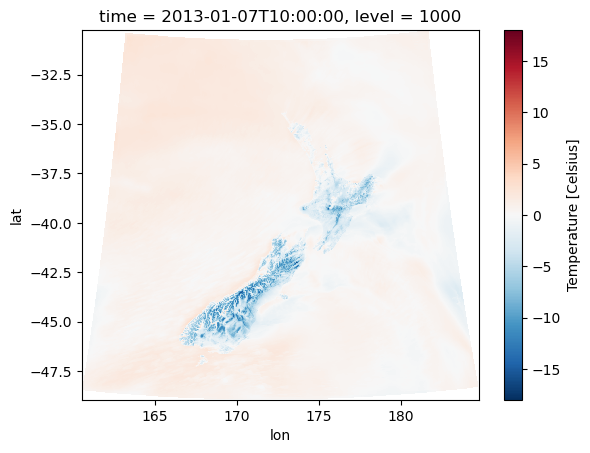

In [9]:
# calculate diffs for target variable in NZRA dataset
# ERA5 and NZRA are on different grids

for var in target_variable:
    var_diff = f"{var}_diff"

    era5_interp = era5_ds[var].interp(lat=nzra_ds.lat, lon=nzra_ds.lon, method="linear")

    nzra_ds[f"{var}_diff"] = nzra_ds[var] - era5_interp

    nzra_ds.isel(time=0)[var_diff].plot()
    plt.show()

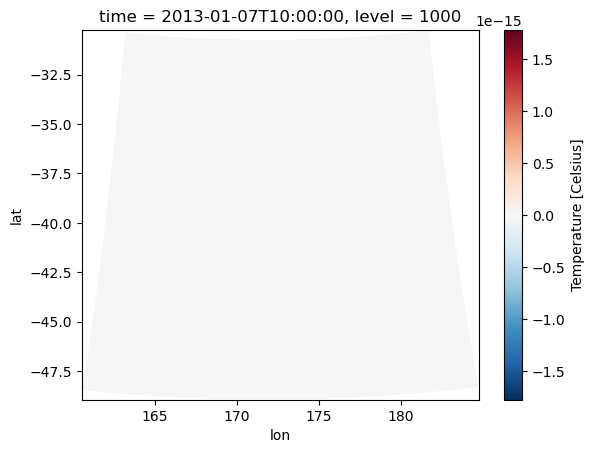

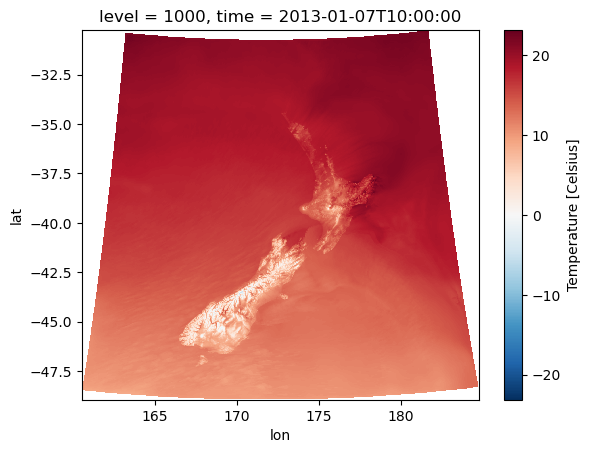

In [10]:
# check that NZRA can be recreated from ERA5 + diff
for var in target_variable:
    var_diff = f"{var}_diff"

    era5_interp = era5_ds[var].interp(lat=nzra_ds.lat, lon=nzra_ds.lon, method="linear")

    nzra_recreated = era5_interp + nzra_ds[var_diff]

    diff = nzra_ds[var] - nzra_recreated

    diff.isel(time=0).plot()
    plt.show()

    nzra_recreated.isel(time=0).plot()
    plt.show()

In [11]:
# crop all datasets to a square bound of lat -32.5, -47.5 and lon 165, 180
crop_bottom = -47.5
crop_top = -32.5
crop_left = 165.0
crop_right = 180.0

nzra_ds = nzra_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
era5_ds = era5_ds.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

#### NZRA
Visualise temperature from the NZRA dataset.

This will be sampled from and used as the target set.

For initial experiments, the target is 'temperature' but will be updated as use-cases require.

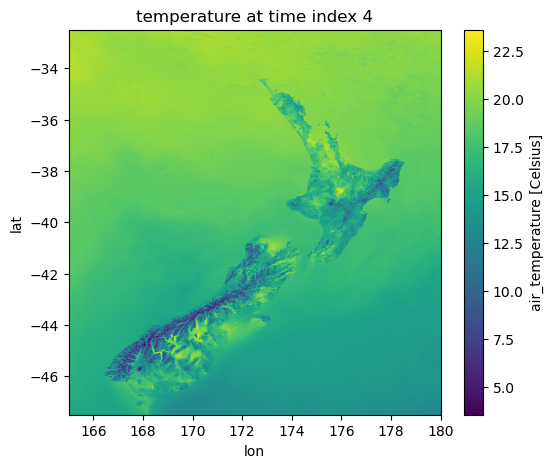

In [12]:
for var in target_variable:
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    nzra_ds[var].isel(time=4).plot(ax=ax)
    plt.title(f"{var} at time index 4")
    plt.show()

#### ERA5
The following six variables together form a closed description of the atmosphere. We may include all these variables in the model.

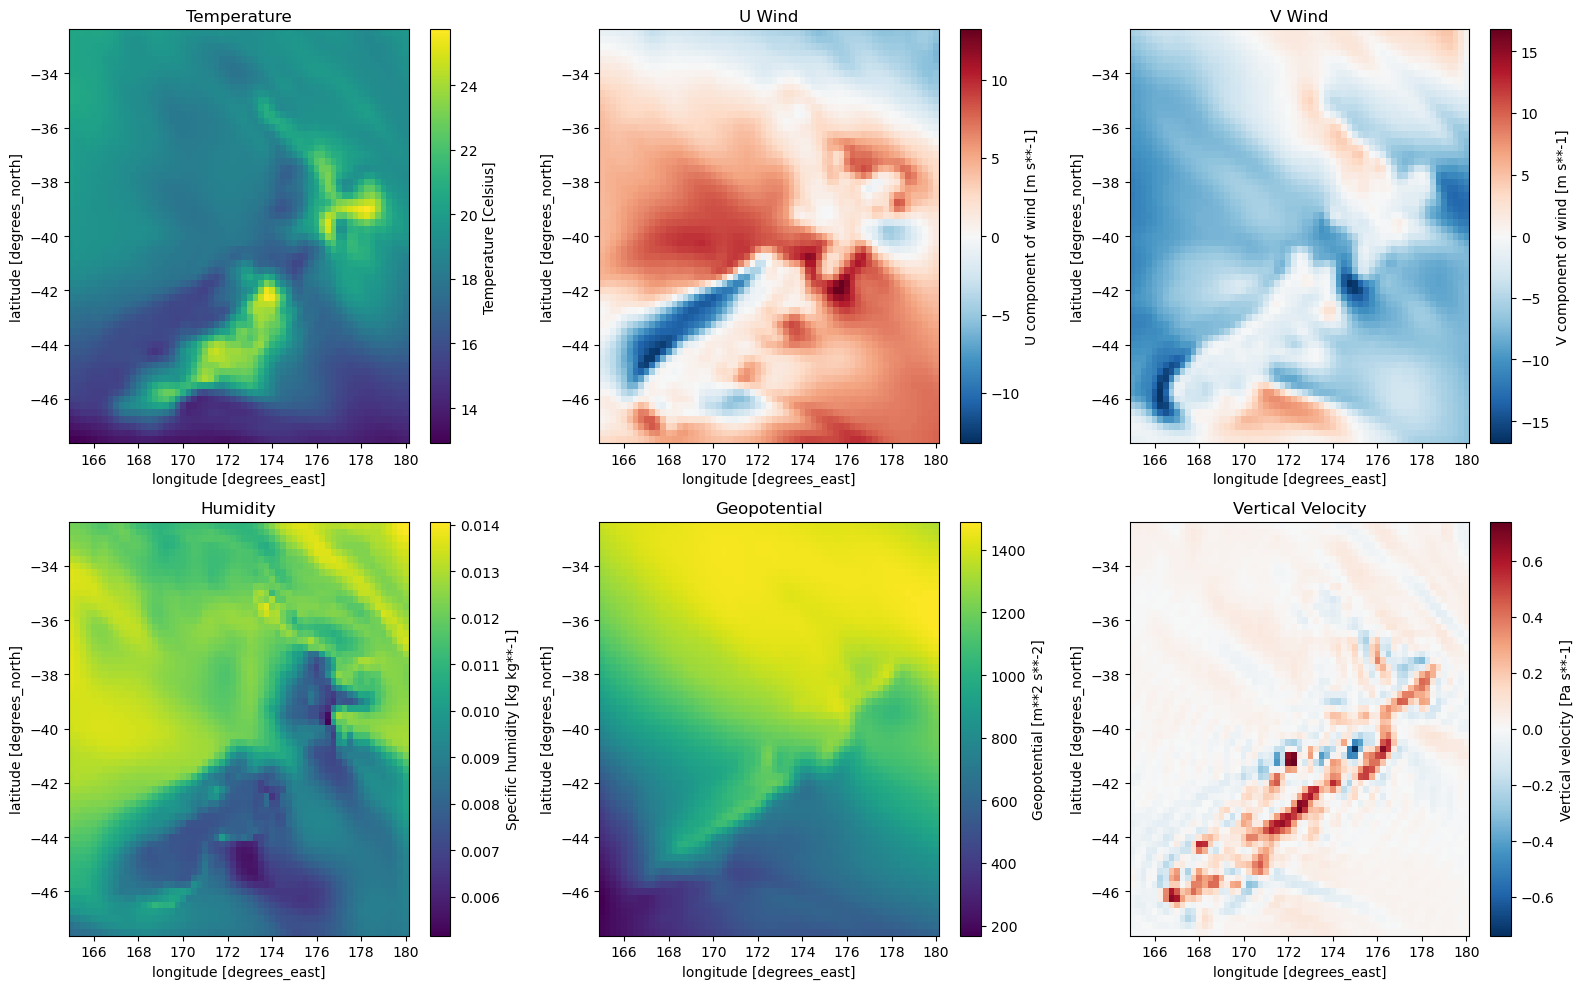

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

era5_ds[TEMPERATURE].isel(time=3).plot(ax=ax[0, 0])
ax[0, 0].set_title("Temperature")

era5_ds[WIND_U].isel(time=3).plot(ax=ax[0, 1])
ax[0, 1].set_title("U Wind")

era5_ds[WIND_V].isel(time=3).plot(ax=ax[0, 2])
ax[0, 2].set_title("V Wind")

era5_ds[HUMIDITY].isel(time=3).plot(ax=ax[1, 0])
ax[1, 0].set_title("Humidity")

era5_ds[GEOPOTENTIAL].isel(time=3).plot(ax=ax[1, 1])
ax[1, 1].set_title("Geopotential")

era5_ds[VERTICAL_VELOCITY].isel(time=3).plot(ax=ax[1, 2])
ax[1, 2].set_title("Vertical Velocity")
plt.tight_layout()

#### Ground Stations

A subset (and arbitrary number) of ground stations will be used as off-grid inputs to the model.

A set of stations can also be used as supplementary target points to NZRA - letting the model learn at spaces off the NZRA grid, and theoretically allowing the model to learn outputs which could be "more correct" than NZRA - provided the stations haven't been assimilated into NZRA.

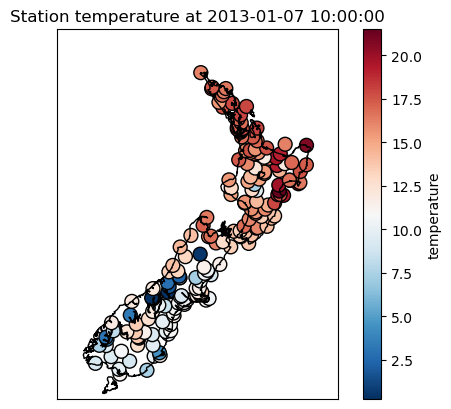

In [14]:
for var in target_variable:
    time_step = stations_resample.reset_index()['time'].unique()[0]
    m = Basemap(projection='merc', llcrnrlat=nzra_ds[LATITUDE].min().item(), urcrnrlat=nzra_ds[LATITUDE].max().item(), llcrnrlon=nzra_ds[LONGITUDE].min().item(), urcrnrlon=nzra_ds[LONGITUDE].max().item(), resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
            stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
    sc = m.scatter(x, y,
                    c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step][var].values,
                    cmap='RdBu_r', marker='o', edgecolor='k', s=100)
    plt.colorbar(sc, label=f'{var}')
    plt.title(f'Station {var} at {time_step}')
    plt.show()

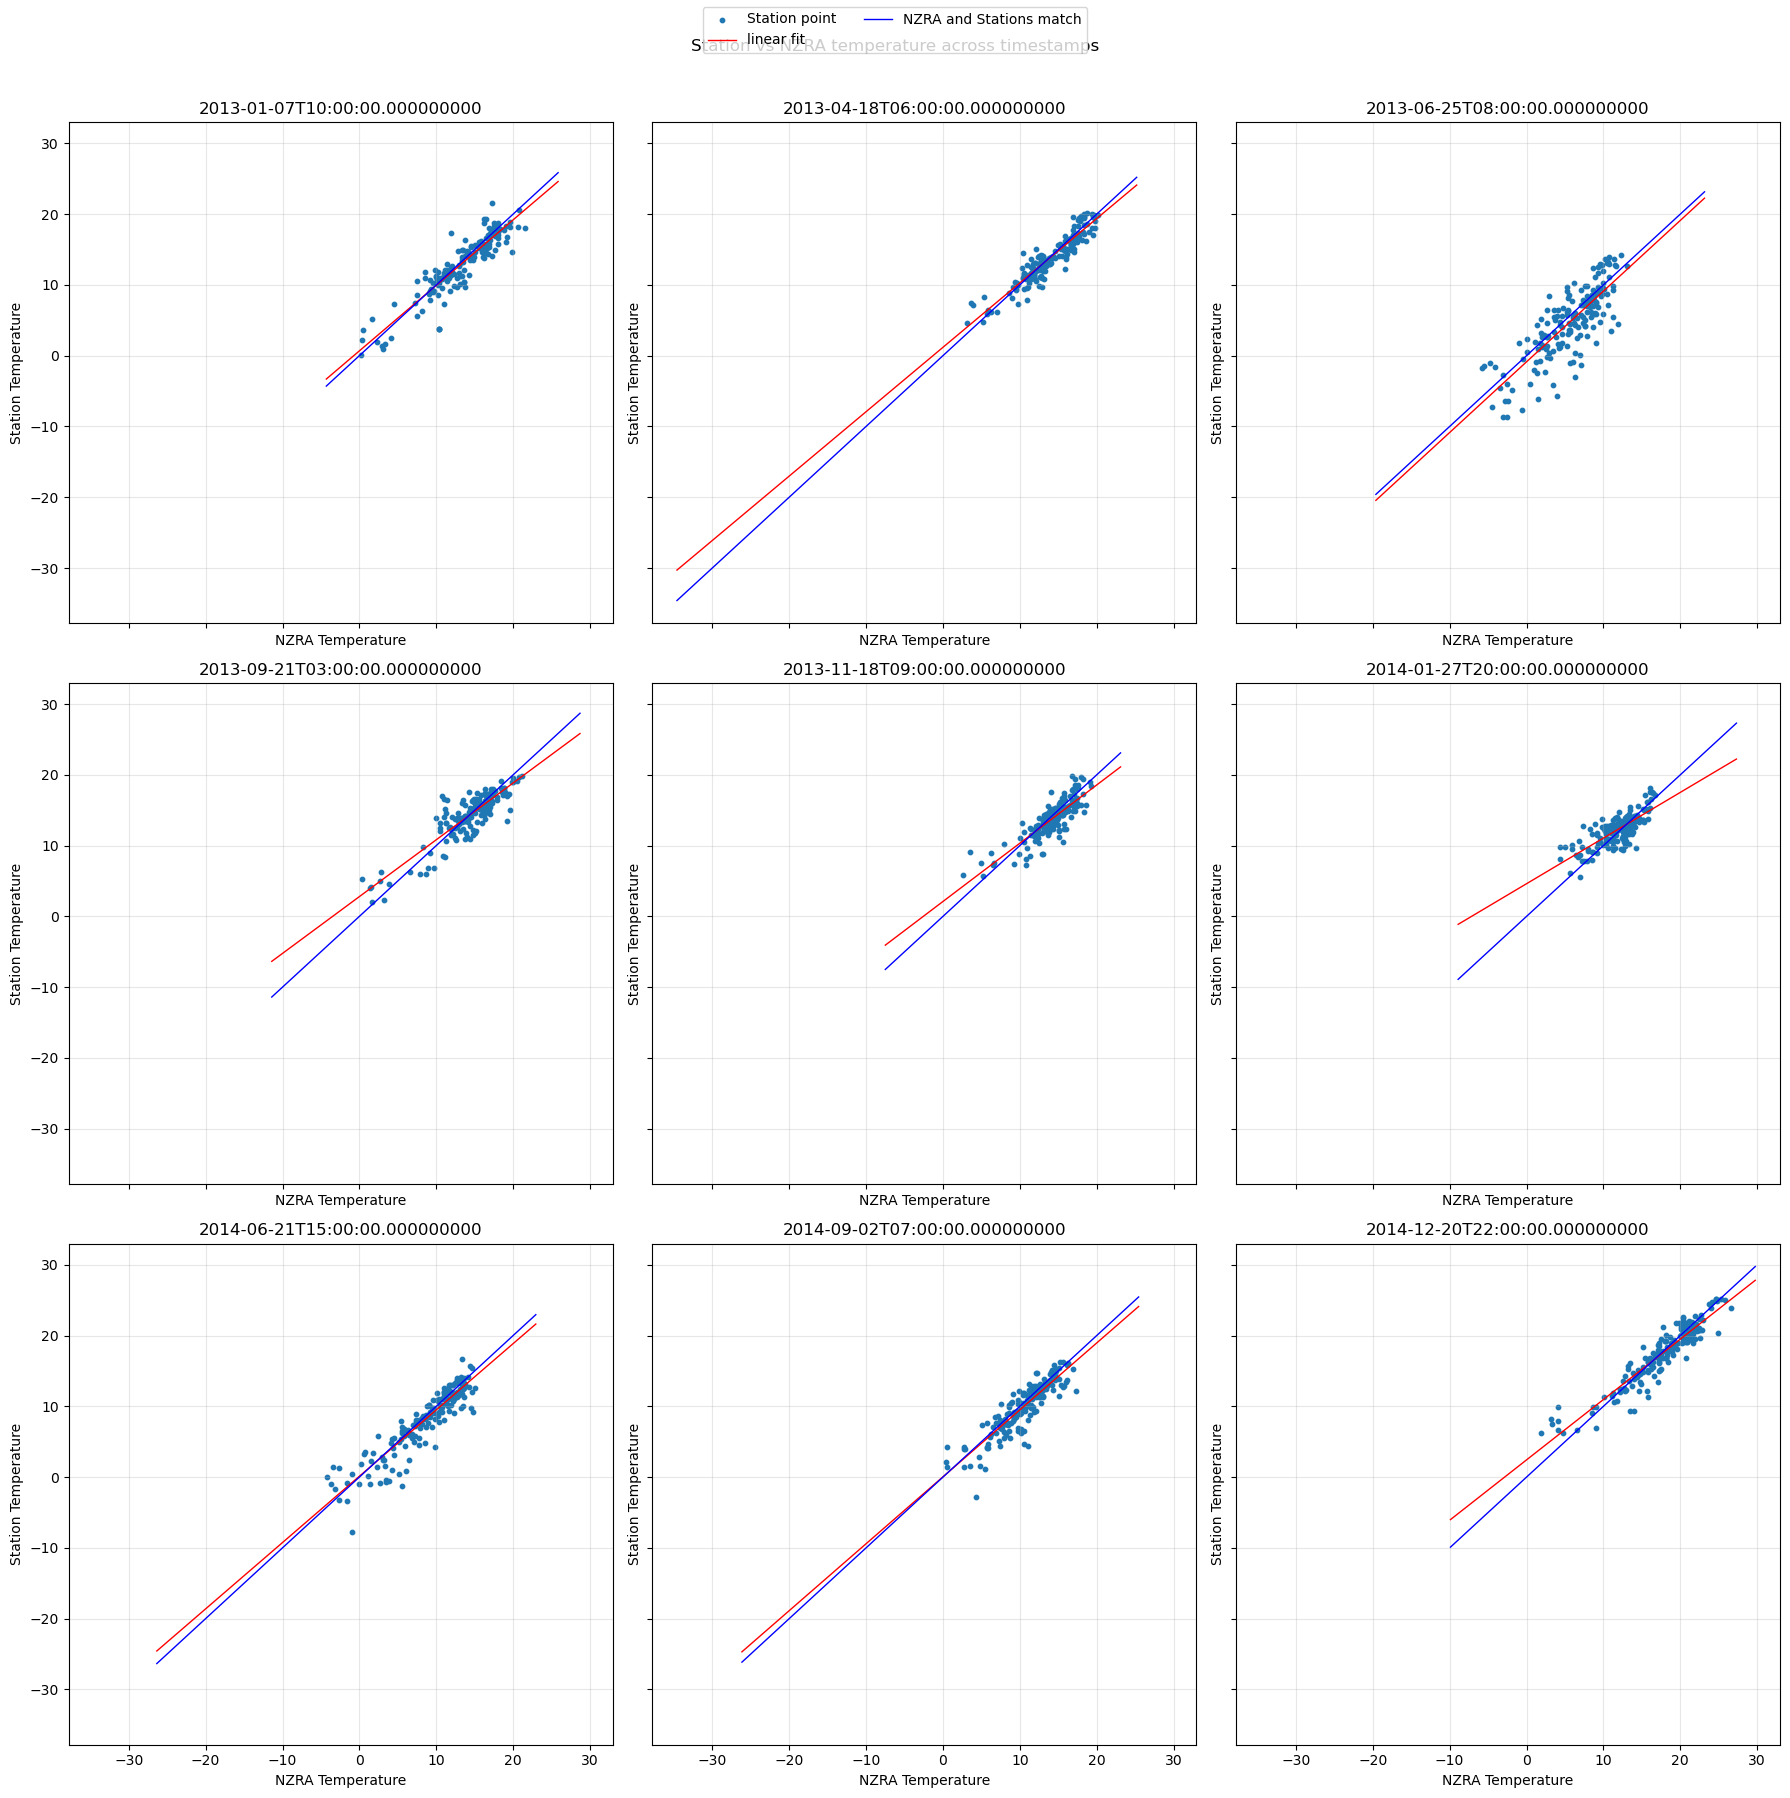

In [15]:
timestamps = nzra_ds[TIME].values

if len(timestamps) < 9:
    raise ValueError("Need at least nine NZRA timestamps to build the validation scatter grid plot.")

timestamp_idx = np.linspace(0, len(timestamps) - 1, 9, dtype=int)
timestamps_to_plot = timestamps[timestamp_idx]
temp_diff_norm_df = None  # placeholder for parity with existing variables
stations_reindex = stations_df.reset_index()

lat0 = -47.492
lon0 = 165.0105
dx = 0.0135

nzra_temp_df = (
    nzra_ds[TEMPERATURE]
    .to_dataframe(name="temperature")
    .reset_index()[["lat", "lon", "time", "temperature"]]
)

stations_df_validate_temp = stations_reindex.copy()

stations_df_validate_temp["nearest_lat_nzra"] = np.round(
    lat0 + np.round((stations_df_validate_temp["lat"] - lat0) / dx) * dx,
    4,
)

stations_df_validate_temp["nearest_lon_nzra"] = np.round(
    lon0 + np.round((stations_df_validate_temp["lon"] - lon0) / dx) * dx,
    4,
)

joined = stations_df_validate_temp.merge(
    nzra_temp_df,
    how="left",
    left_on=["nearest_lat_nzra", "nearest_lon_nzra", "time"],
    right_on=["lat", "lon", "time"],
).rename(
    columns={"temperature_x": "station_temperature", "temperature_y": "nzra_temperature"}
)

fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

for ax, timestamp_temp_validation in zip(axes.ravel(), timestamps_to_plot):
    
    joined_filtered = joined[joined['time'] == timestamp_temp_validation]

    line = np.linspace(
        joined_filtered["station_temperature"].min(),
        joined_filtered["station_temperature"].max(),
        100,
    )

    ax.scatter(
        joined_filtered["station_temperature"],
        joined_filtered["nzra_temperature"],
        label="Station point",
        s=10,
    )

    lineregdf = joined_filtered[['station_temperature', 'nzra_temperature']]
    lineregdf = lineregdf.dropna()

    fit = np.polyfit(lineregdf["station_temperature"], lineregdf["nzra_temperature"], 1)

    p = np.poly1d(fit)

    ax.plot(line, p(line), label="linear fit", c="red", linewidth=1)
    ax.plot(line, line, label="NZRA and Stations match", c="blue", linewidth=1)
    ax.set_xlabel("NZRA Temperature")
    ax.set_ylabel("Station Temperature")
    ax.set_title(str(timestamp_temp_validation))
    ax.grid(True, alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
fig.suptitle("Station vs NZRA temperature across timestamps")
plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()


In [16]:
# only select temperature + sun position from ERA5
era5_ds = era5_ds[[TEMPERATURE]]

# regrid ERA5 to NZRA grid using linear interpolation
era5_ds = era5_ds.chunk({"time": 1, "lat": 61, "lon": 61})
era5_ds = era5_ds.interp(lat=nzra_ds.lat, lon=nzra_ds.lon, method="linear")

# filter NZRA to only land points using the land-sea mask. Set sea points to NaN so they are ignored during training and evaluation
#nzra_ds = nzra_ds.where(nzra_ds[LAND_SEA_MASK] == 1)

# select the diffs from NZRA as targets
nzra_ds = nzra_ds[target_variable + target_variable_diff]

In [17]:
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))

/esi/project/niwa00004/crowelenn/dev/deepsensor/deepsensor/data/processor.py:128: UserWarning: x1_map and x2_map have different ranges.This can lead to stretching/squashing of data, which may impact model performance.
  warnings.warn(


In [18]:
%autoreload 2
from convcnp_assim_nz.data_processing.normalize.coordinate_normalizer import CoordinateNormalizer

In [19]:
# filter the stations to be within the bounds of the ERA5 grid
stations_df = stations_df[(stations_df[LATITUDE] >= era5_ds[LATITUDE].min().item()) & (stations_df[LATITUDE] <= era5_ds[LATITUDE].max().item()) &
                          (stations_df[LONGITUDE] >= era5_ds[LONGITUDE].min().item()) & (stations_df[LONGITUDE] <= era5_ds[LONGITUDE].max().item())]

In [20]:
# build the residual station error

stations_df['nearest_lat'] = (stations_df['lat']*4).round()/4
stations_df['nearest_lon'] = (stations_df['lon']*4).round()/4

# filter era5_ds to only the nearest lat/lon points to the stations, to speed up the join operation when building the residual station error
era5_ds_filtered = era5_ds.sel(lat=stations_df['nearest_lat'].unique(), lon=stations_df['nearest_lon'].unique(), method="nearest")

temp_df = era5_ds_filtered[TEMPERATURE].to_dataframe()

temp_df['lat_round'] = (temp_df.index.get_level_values('lat')*4).round()/4
temp_df['lon_round'] = (temp_df.index.get_level_values('lon')*4).round()/4

In [21]:
# join stations with ERA5 data
stations_reset = stations_df.reset_index()
stations_era5 = stations_reset.merge(temp_df.reset_index(), how='left', left_on=['time', 'nearest_lat', 'nearest_lon'], right_on=['time', 'lat_round', 'lon_round'], suffixes=('', '_era5'))

In [22]:
stations_era5['residual'] = stations_era5[TEMPERATURE] - stations_era5[f"{TEMPERATURE}_era5"]

In [23]:
stations_era5.head()

,index,temperature,lat,lon,time,AGENT_NO,NAME,nearest_lat,nearest_lon,lat_era5,lon_era5,level,temperature_era5,lat_round,lon_round,residual
0,28777,14.30,-45.25366,169.39205,2013-01-07 10:00:00,36592,ALEXANDRA CWS,-45.25,169.50,-45.2510,169.5060,1000,12.448183,-45.25,169.50,1.851817
1,28778,13.80,-45.20342,169.31820,2013-01-07 10:00:00,39564,CLYDE 2 EWS,-45.25,169.25,-45.2510,169.2495,1000,11.550168,-45.25,169.25,2.249832
2,28779,13.15,-42.68168,171.45628,2013-01-07 10:00:00,26104,PIGEON CREEK CWS,-42.75,171.50,-42.7535,171.5040,1000,11.056861,-42.75,171.50,2.093139
3,28780,2.90,-43.13409,170.91264,2013-01-07 10:00:00,36733,IVORY GLACIER CWS,-43.25,171.00,-43.2530,171.0045,1000,11.371911,-43.25,171.00,-8.471911
4,28781,16.40,-41.31727,173.09482,2013-01-07 10:00:00,21937,APPLEBY 2 EWS,-41.25,173.00,-41.2550,173.0025,1000,14.879904,-41.25,173.00,1.520096


In [24]:
normalizer = CoordinateNormalizer()

stations_norm, nzra_norm = normalizer([stations_era5[['residual', TIME, LATITUDE, LONGITUDE]], nzra_ds[[f"{TEMPERATURE}_diff"]]])

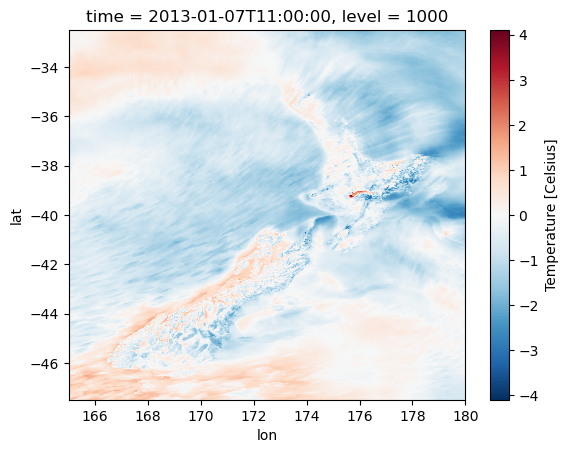

In [25]:
nzra_norm.isel(time=1)[f"{TEMPERATURE}_diff_norm"].plot()

(array([ 3.,  4.,  5.,  8.,  4.,  9.,  6.,  6., 11.,  7.,  3.,  4.,  2.,
         1.,  2.,  3.,  2.,  1.,  0.,  1.]),
 array([-1.75010356, -1.52122559, -1.29234762, -1.06346966, -0.83459169,
        -0.60571372, -0.37683575, -0.14795779,  0.08092018,  0.30979815,
         0.53867612,  0.76755408,  0.99643205,  1.22531002,  1.45418799,
         1.68306595,  1.91194392,  2.14082189,  2.36969986,  2.59857782,
         2.82745579]),
 <BarContainer object of 20 artists>)

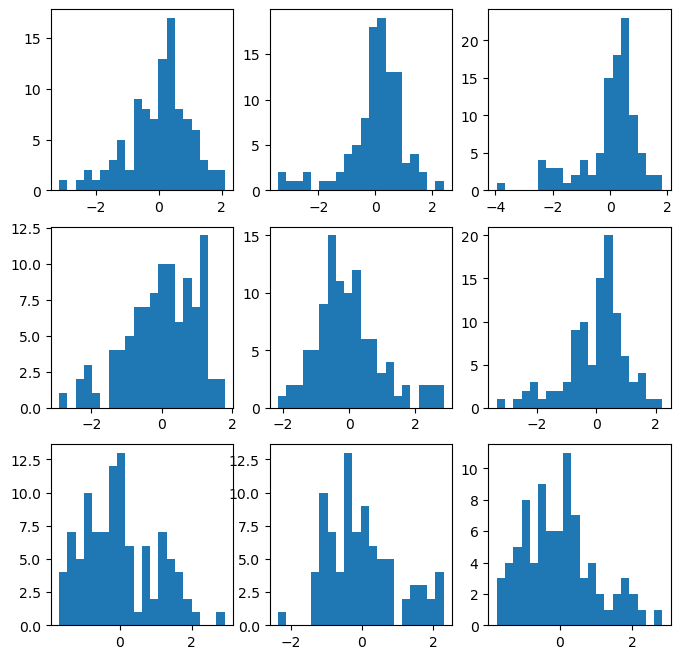

In [26]:
# check that the normalized diffs have mean ~0 and std ~1 for a few stations by plotting some histograms


fig, ax = plt.subplots(3, 3, figsize=(8,8))
ax[0,0].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -40.61986) & (stations_norm.index.get_level_values('lon') == 175.25954)]["residual_norm"], bins=20)
ax[0,1].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -40.90455) & (stations_norm.index.get_level_values('lon') == 174.98517)]["residual_norm"], bins=20)
ax[0,2].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -38.28566) & (stations_norm.index.get_level_values('lon') == 177.52941)]["residual_norm"], bins=20)
ax[1,0].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -41.27058) & (stations_norm.index.get_level_values('lon') == 172.15568)]["residual_norm"], bins=20)
ax[1,1].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -42.01777) & (stations_norm.index.get_level_values('lon') == 172.64677)]["residual_norm"], bins=20)
ax[1,2].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -45.90129) & (stations_norm.index.get_level_values('lon') == 170.51470)]["residual_norm"], bins=20)
ax[2,0].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -45.22172) & (stations_norm.index.get_level_values('lon') == 167.62988)]["residual_norm"], bins=20)
ax[2,1].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -43.13409) & (stations_norm.index.get_level_values('lon') == 170.91264)]["residual_norm"], bins=20)
ax[2,2].hist(stations_norm[(stations_norm.index.get_level_values('lat') == -44.83407) & (stations_norm.index.get_level_values('lon') == 167.77752)]["residual_norm"], bins=20)


In [27]:
# Dataset preparation: build reusable, filtered NZRA/stations datasets

timestamps = nzra_norm[TIME].values
if len(timestamps) < 9:
    raise ValueError("Need at least nine NZRA timestamps to build the validation grid plot.")

timestamp_idx = np.linspace(0, len(timestamps) - 1, 9, dtype=int)
timestamps_to_plot = timestamps[timestamp_idx]

# Grid quantisation parameters for mapping station coords to NZRA grid

lat0 = -47.492
lon0 = 165.0105
dx = 0.0135 # nzra resolution in degrees

# Prepare stations dataframe once (including nearest NZRA grid coordinates)
stations_reindex = stations_norm.reset_index().copy()
stations_reindex["nearest_lat_nzra"] = np.round(lat0 + np.round((stations_reindex["lat"] - lat0) / dx) * dx, 4)

stations_reindex["nearest_lon_nzra"] = np.round(lon0 + np.round((stations_reindex["lon"] - lon0) / dx) * dx, 4)

# Filter NZRA to only the coordinates that are actually used by stations
unique_lats = stations_reindex["nearest_lat_nzra"].unique()
unique_lons = stations_reindex["nearest_lon_nzra"].unique()
nzra_norm_subset = nzra_norm.sel(lat=unique_lats, lon=unique_lons, method="nearest")

# Build a single NZRA temperature-diff-normalised dataframe for all times/coords
temp_diff_norm_all = (
    nzra_norm_subset
    [f"{TEMPERATURE}_diff_norm"]
    .to_dataframe(name="temperature_diff_norm")
    .reset_index()[["time", "lat", "lon", "temperature_diff_norm"]]
)

joined_norm = stations_reindex.merge(
        temp_diff_norm_all,
        how="left",
        left_on=["nearest_lat_nzra", "nearest_lon_nzra", "time"],
        right_on=["lat", "lon", "time"],
    )

stations_names = stations_df[['lat', 'lon', 'AGENT_NO', 'NAME']].drop_duplicates()

# join on station ids per lat/lon
joined_norm = joined_norm.merge(
    stations_names,
    how='left',
    left_on=['lat_x', 'lon_x'],
    right_on=['lat', 'lon']
)

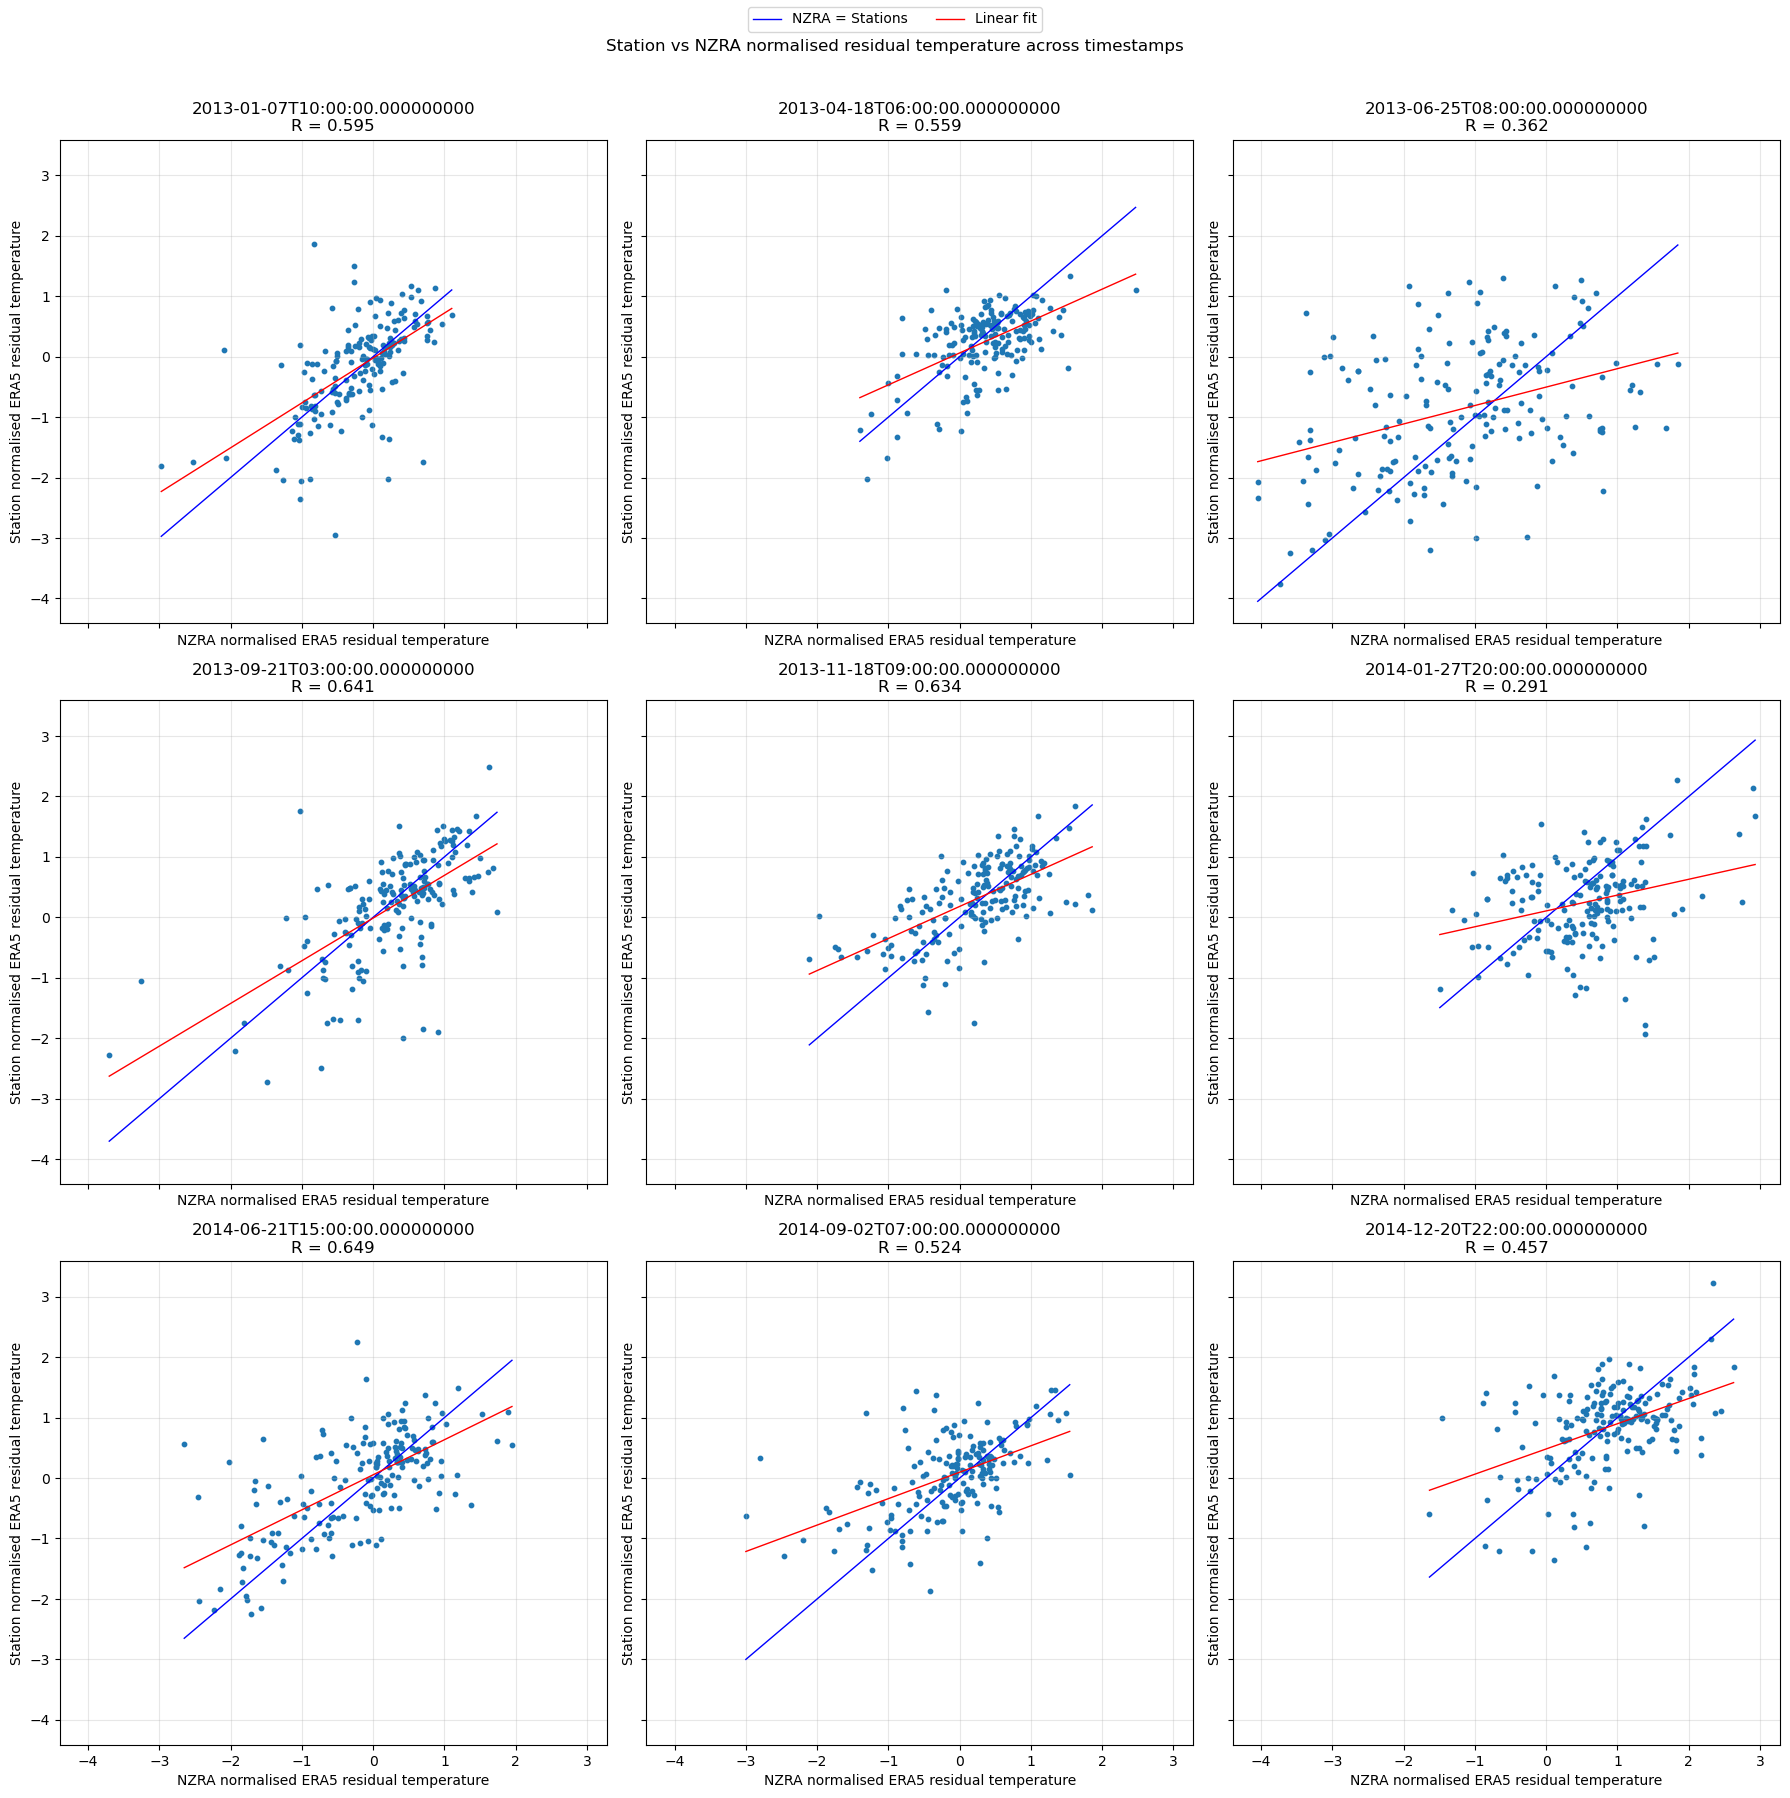

In [28]:
# Plotting logic: sample from pre-built datasets inside the loop
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

for ax, timestamp_temp_validation in zip(axes.ravel(), timestamps_to_plot):
    # Sample NZRA diffs for this timestamp
    #temp_diff_norm_df = temp_diff_norm_all[temp_diff_norm_all["time"] == timestamp_temp_validation][["lat", "lon", "temperature_diff_norm"]]

    # Sample station residuals for this timestamp
    #stations_df_validate_temp = stations_reindex[stations_reindex["time"] == timestamp_temp_validation].copy()

    # Join on precomputed nearest NZRA coordinates
    
    joined_filtered = joined_norm[joined_norm["time"] == timestamp_temp_validation]

    line = np.linspace(joined_filtered["temperature_diff_norm"].min(),joined_filtered["temperature_diff_norm"].max(),100,)

    valid_data = joined_filtered[["temperature_diff_norm", "residual_norm"]].dropna()
    if len(valid_data) > 1:
        r_value = np.corrcoef(valid_data["temperature_diff_norm"], valid_data["residual_norm"])[0, 1]
    else:
        r_value = np.nan

    lineregdf = joined_filtered[['temperature_diff_norm', 'residual_norm']]
    lineregdf = lineregdf.dropna()

    fit = np.polyfit(lineregdf["temperature_diff_norm"], lineregdf["residual_norm"], 1)

    p = np.poly1d(fit)

    ax.scatter(joined_filtered["temperature_diff_norm"],joined_filtered["residual_norm"],s=10,)

    ax.plot(line, line, label="NZRA = Stations", c="blue", linewidth=1)
    ax.plot(line, p(line), label="Linear fit", c="red", linewidth=1)
    ax.set_xlabel("NZRA normalised ERA5 residual temperature")
    ax.set_ylabel("Station normalised ERA5 residual temperature")
    ax.set_title(f"{timestamp_temp_validation}\nR = {r_value:.3f}")
    ax.grid(True, alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
fig.suptitle("Station vs NZRA normalised residual temperature across timestamps")
plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()

In [29]:
joined_norm.head()

,time,lat_x,lon_x,residual_norm,nearest_lat_nzra,nearest_lon_nzra,lat_y,lon_y,temperature_diff_norm,lat,lon,AGENT_NO,NAME
0,2013-01-07 10:00:00,-45.25366,169.39205,1.094196,-45.2510,169.398,-45.2510,169.398,0.627284,-45.25366,169.39205,36592,ALEXANDRA CWS
1,2013-01-07 10:00:00,-45.20342,169.31820,0.888751,-45.1970,169.317,-45.1970,169.317,0.251520,-45.20342,169.31820,39564,CLYDE 2 EWS
2,2013-01-07 10:00:00,-42.68168,171.45628,0.778016,-42.6860,171.450,-42.6860,171.450,0.427008,-42.68168,171.45628,26104,PIGEON CREEK CWS
3,2013-01-07 10:00:00,-43.13409,170.91264,-0.269550,-43.1315,170.910,-43.1315,170.910,-0.187604,-43.13409,170.91264,36733,IVORY GLACIER CWS
4,2013-01-07 10:00:00,-41.31727,173.09482,0.715217,-41.3225,173.097,-41.3225,173.097,0.395043,-41.31727,173.09482,21937,APPLEBY 2 EWS


In [30]:
# calculate the MSE per station
mse_per_station = joined_norm.groupby('AGENT_NO').apply(
    lambda group: ((group['residual_norm'] - group['temperature_diff_norm']) ** 2).mean()
).reset_index(name='MSE')

# merge with station names for reference
mse_per_station = mse_per_station.merge(
    stations_names[['AGENT_NO', 'NAME']].drop_duplicates(),
    on='AGENT_NO',
    how='left'
)

mse_per_station.sort_values('MSE', ascending=False)

/var/tmp/pbs.1613842.pbsserver01/ipykernel_4106855/93378782.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_per_station = joined_norm.groupby('AGENT_NO').apply(


,AGENT_NO,MSE,NAME
162,37870,1.712931,CAPE KIDNAPPERS WXT AWS
139,36857,1.535795,MAHANGA EWS
19,2685,1.531993,NGAWI AWS
147,37256,1.529628,CAPE TURNAGAIN AWS
143,37047,1.501178,TAKAHE VALLEY CWS
...,...,...,...
20,2692,0.250653,HICKS BAY AWS
103,25643,0.241085,TURANGI 2 EWS
24,3126,0.239565,"WAIROA, NORTH CLYDE EWS"
104,25777,0.224041,ARAPITO EWS


Text(0.5, 1.0, 'MSE per station')

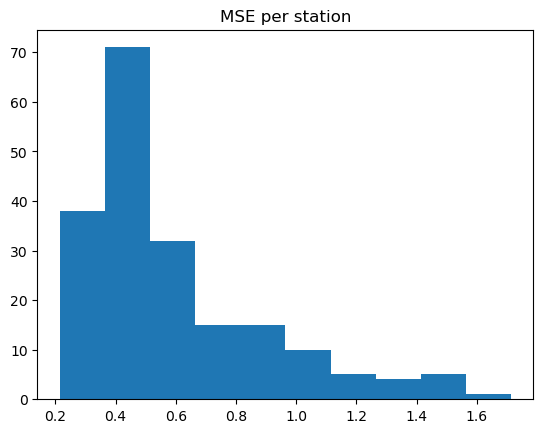

In [31]:
plt.hist(mse_per_station['MSE'])
plt.title('MSE per station')

In [32]:
# select the top n station ids with lowest MSE

n = 30

best_stations = mse_per_station.sort_values('MSE', ascending=True)[0:n]

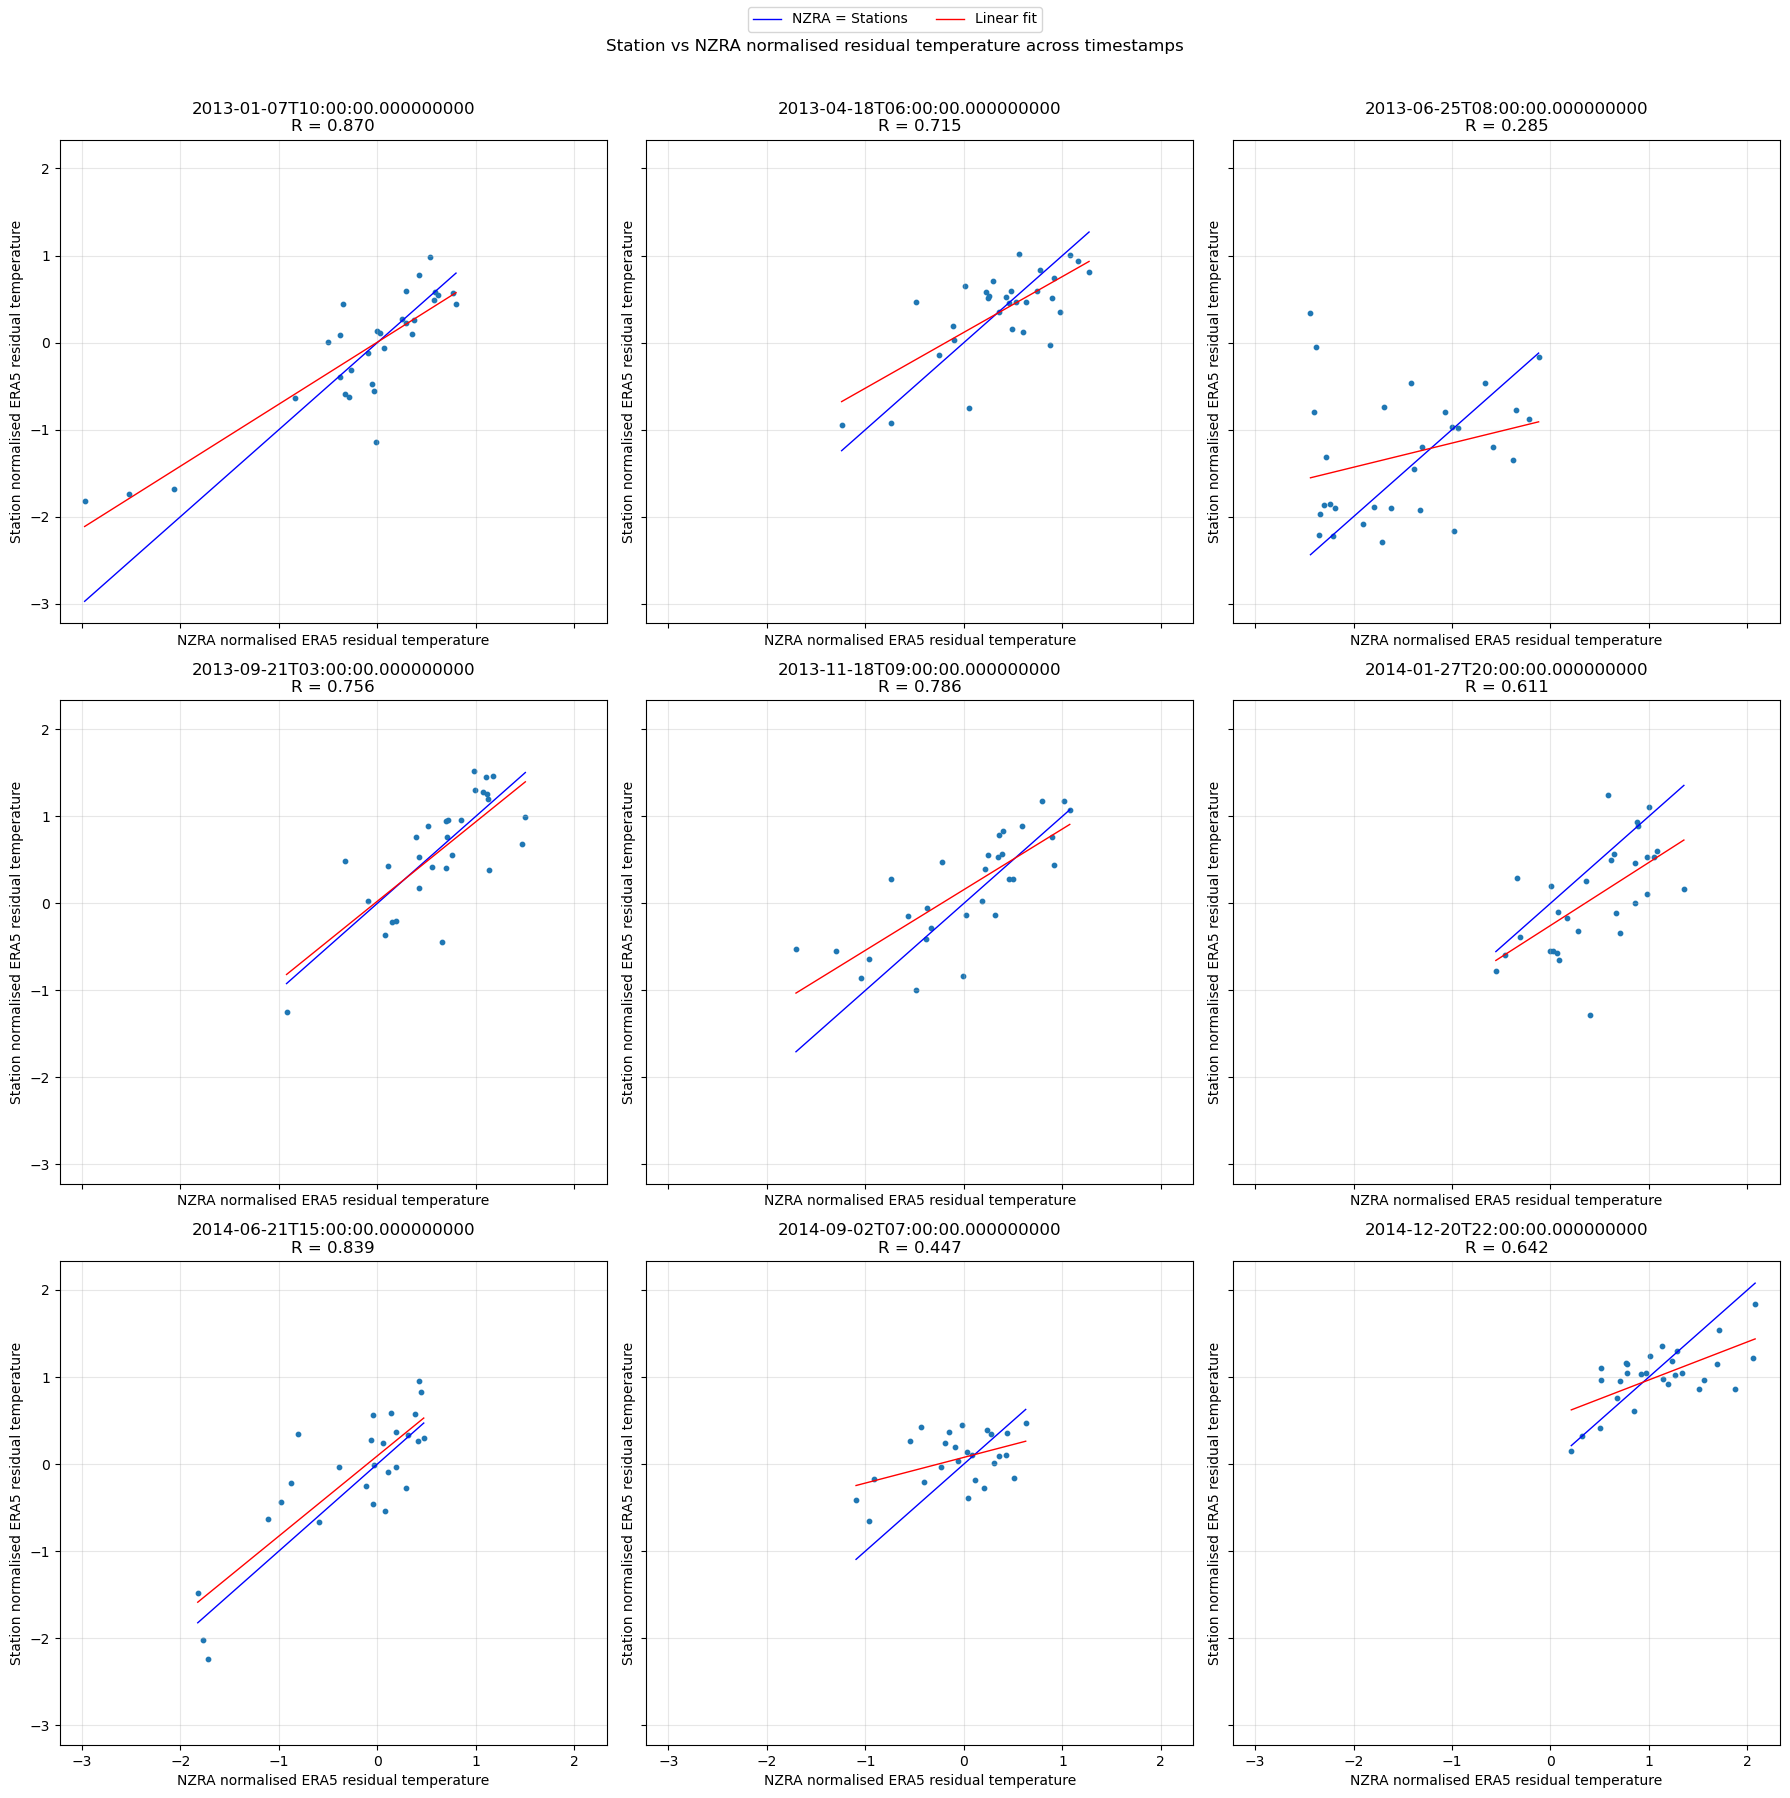

In [33]:
joined_filtered_best_stations = joined_norm[joined_norm['AGENT_NO'].isin(best_stations['AGENT_NO'].values)]

# Plotting logic: sample from pre-built datasets inside the loop
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

for ax, timestamp_temp_validation in zip(axes.ravel(), timestamps_to_plot):
    # Sample NZRA diffs for this timestamp
    #temp_diff_norm_df = temp_diff_norm_all[temp_diff_norm_all["time"] == timestamp_temp_validation][["lat", "lon", "temperature_diff_norm"]]

    # Sample station residuals for this timestamp
    #stations_df_validate_temp = stations_reindex[stations_reindex["time"] == timestamp_temp_validation].copy()

    # Join on precomputed nearest NZRA coordinates
    
    joined_filtered = joined_filtered_best_stations[joined_filtered_best_stations["time"] == timestamp_temp_validation]

    line = np.linspace(joined_filtered["temperature_diff_norm"].min(),joined_filtered["temperature_diff_norm"].max(),100,)

    valid_data = joined_filtered[["temperature_diff_norm", "residual_norm"]].dropna()
    if len(valid_data) > 1:
        r_value = np.corrcoef(valid_data["temperature_diff_norm"], valid_data["residual_norm"])[0, 1]
    else:
        r_value = np.nan

    fit = np.polyfit(joined_filtered["temperature_diff_norm"],joined_filtered["residual_norm"],1,)

    p = np.poly1d(fit)

    ax.scatter(joined_filtered["temperature_diff_norm"],joined_filtered["residual_norm"],s=10,)

    ax.plot(line, line, label="NZRA = Stations", c="blue", linewidth=1)
    ax.plot(line, p(line), label="Linear fit", c="red", linewidth=1)
    ax.set_xlabel("NZRA normalised ERA5 residual temperature")
    ax.set_ylabel("Station normalised ERA5 residual temperature")
    ax.set_title(f"{timestamp_temp_validation}\nR = {r_value:.3f}")
    ax.grid(True, alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
fig.suptitle("Station vs NZRA normalised residual temperature across timestamps")
plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()